In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
from google.colab import drive
drive.mount('/content/drive')
device='cuda' if torch.cuda.is_available() else 'cpu'
# print(torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
filename='/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_ISF.txt'
S_isf=pd.read_table(filename,sep=',',header=None).to_numpy() # ISF matrix
filename='/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit
n_line = np.size(S_isf,0)
S = torch.from_numpy(S_isf).to(device) # ISF
f_max = torch.from_numpy(f_max).to(device) # flow limit

In [3]:
print(S.shape,f_max.shape,torch.min(f_max))
print(torch.min(f_max),torch.max(f_max))
print(f_max[0:5])

torch.Size([1991, 1354]) torch.Size([1991, 1]) tensor(281., dtype=torch.float64)
tensor(281., dtype=torch.float64) tensor(157840., dtype=torch.float64)
tensor([[39412.],
        [  319.],
        [ 7252.],
        [  657.],
        [ 1315.]], dtype=torch.float64)


In [4]:

# Normal cases
x=np.load('/content/drive/MyDrive/gnn/data/data_1354ac_2022/ac1354_x.npy')
y=np.load('/content/drive/MyDrive/gnn/data/data_1354ac_2022/ac1354_y.npy')
W=np.load('/content/drive/MyDrive/gnn/data/data_1354ac_2022/ac1354_w.npy')
# W=np.load('/content/drive/MyDrive/gnn/data/ac118_p10_w.npy')
print(x.shape,y.shape)
print(np.max(x),np.min(x),np.max(y),np.min(y))

# scaling on voltage
print('original voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))
y[:,1,:] = (y[:,1,:] - 0.9) * 100
print('scaled voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x.transpose(),y.transpose(),test_size=0.2, random_state=18)
x_train=x_train.transpose()
x_test=x_test.transpose()
y_train=y_train.transpose()
y_test=y_test.transpose()
print('Training data size:',x_train.shape)
print('Training label size:',y_train.shape)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, labels, device='cpu'):
        self.features=torch.from_numpy(np.transpose(features)).float().to(device)
        self.labels=torch.from_numpy(np.transpose(labels)).float().to(device)
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        # Select sample
        X = self.features[idx]  # shape = (24,)
        y = self.labels[idx]    # shape = (24,)
        X = torch.reshape(X,(6,1354))
        y = torch.reshape(y,(2,1354))
        return X, y
params = {'batch_size': 256,
          'shuffle': True,
          'num_workers': 0}
# Dataset Generators
training_set = Dataset(features=x_train,labels=y_train,device=device)
training_generator = torch.utils.data.DataLoader(training_set,**params)
validation_set = Dataset(features=x_test,labels=y_test,device=device)
validation_generator = torch.utils.data.DataLoader(validation_set,**params)

(1354, 6, 7912) (1354, 2, 7912)
5864.5 -2178.4 107920.0 -52503.0
original voltage: 0.88572 1.1343
scaled voltage: -1.428000000000007 23.430000000000007
Training data size: (1354, 6, 6329)
Training label size: (1354, 2, 6329)


In [5]:
# voltage range
print('voltage:',np.min(y[:,1,:]),np.max(y[:,1,:]))
print('price:',np.min(y[:,0,:]),np.max(y[:,0,:]))


voltage: -1.428000000000007 23.430000000000007
price: -52503.0 107920.0


Text(0.5, 1.0, 'price')

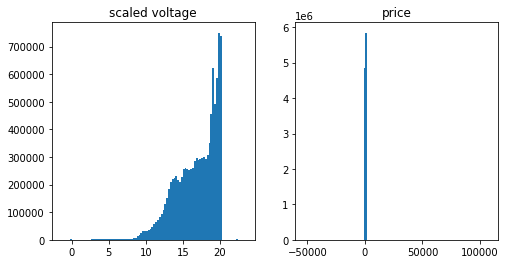

In [6]:
fig2 = plt.figure(figsize=(8, 4))
flat_list = list(np.concatenate(y[:,1,:]).flat)
flat_list3 = list(np.concatenate(y[:,0,:]).flat)
plt.subplot(1,2,1)
plt.hist(flat_list,bins = 100)
plt.title('scaled voltage')
plt.subplot(1,2,2)
plt.hist(flat_list3,bins = 100)
plt.title('price')
# plt.plot(err_L2,'bo',markersize=0.5,label = 'L2 error')

In [7]:
filename='/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_p_inj.txt'
p_inj0=pd.read_table(filename,sep=',',header=None).to_numpy() # true P injection 

In [8]:
p_inj0

array([[-1.7245  , -1.6429  , -1.7683  , ..., -1.3418  , -1.4598  ,
        -1.2749  ],
       [-2.0485  , -1.6465  , -1.3804  , ..., -1.8349  , -1.9828  ,
        -1.31    ],
       [-1.1564  , -1.7256  , -1.2783  , ..., -1.0199  , -1.3409  ,
        -1.0677  ],
       ...,
       [ 0.06227 ,  0.05955 ,  0.040527, ...,  0.065627,  0.040483,
         0.065748],
       [-2.6847  , -2.4219  , -2.2143  , ..., -2.2682  , -2.6329  ,
        -1.9884  ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [9]:
n_val = 1000
x_validation = x[:,:,:n_val].copy() # (1354, 6, 1000)
y_validation = y[:,:,:n_val].copy() # (1354, 2, 1000)

load0 = -x[:,1,:].copy() # load file

p_inj_true = p_inj0[:,:n_val].copy()






In [49]:
# Bbus and B_r inverse
filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_Bbus.txt'
Bbus=pd.read_table(filename1,sep=',',header=None).to_numpy()
B_r = np.delete(Bbus,639,axis=0) # ref bus 640
B_r = np.delete(B_r,639,axis=1)

Br_inv = np.linalg.inv(B_r)

# # Y = G + jB
# filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee118_Gmat.txt'
# G_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
# filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee118_Bmat.txt'
# B_mat=pd.read_table(filename1,sep=',',header=None).to_numpy()
# print(G_mat.shape,B_mat.shape)

# line parameters
filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_lineloc.txt'
line_loc = pd.read_table(filename1,sep=',',header=None).to_numpy()
# line_entry_loc = np.nonzero(G_mat) # index of nonzero entries
# # not in p.u.
# G_line = np.zeros(n_line)
# B_line = np.zeros(n_line)

# # print(line_loc.shape) #[186,2]
# for i in range(n_line):
#   G_line[i] = G_mat[line_loc[i,0]-1,line_loc[i,1]-1]
#   B_line[i] = B_mat[line_loc[i,0]-1,line_loc[i,1]-1]

# load line params
filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_lineparams_tap.txt'
line_params = pd.read_table(filename1,sep=',',header=None).to_numpy()

n_line = 1751
line_loc = line_loc[:n_line,:].copy()
line_params = line_params[:n_line,:].copy()

filename2 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_Ybus.txt'
Y_bus = pd.read_table(filename2,sep=',',header=None).to_numpy()

# G_line = line_params[:,0].copy()
# B_line = line_params[:,1].copy()
R_line = line_params[:,0].copy()
X_line = line_params[:,1].copy()

B_shunt = line_params[:,2].copy()

Z_line = R_line + 1j * X_line 
Y_line = 1 / Z_line

G_line = np.real(Y_line)
B_line = np.imag(Y_line)

# P_inj w/out reference bus in p.u.
# p_inj_r = np.delete(p_inj,639,axis=0) / 100
p_inj_true_r = np.delete(p_inj_true,639,axis=0) #/ 100 already p.u.

# p_inj_pu = p_inj / 100
p_inj_true_pu = p_inj_true / 100

print('B_r inv and p_inj:',Br_inv.shape,p_inj_true.shape)#p_inj_true

# calculate angle (w/our reference at 640th node)
# theta0 = np.matmul(Br_inv,p_inj_r)
theta_true0 = np.matmul(Br_inv,p_inj_true_r)

# theta = np.insert(theta0,639,0,axis = 0)
theta_true = np.insert(theta_true0,639,0,axis = 0)

# filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_theta.txt'
filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_ieee1354_theta1.txt' # 03092022 radian
theta1 = pd.read_table(filename1,sep=',',header=None).to_numpy()
# theta = theta / 180 * math.pi

# print('theta: ',theta_true.shape)
# theta = theta_true.copy() # calculated
theta = theta1.copy() # true
print('theta: ',theta.shape)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,2,4,5,6,8,9,10,11,14,16,17,18,19,20,21,24,25,27,28,30,32,33,36,37,38,41,42,43,44,45,47,48,49,50,52,55,56,58,61,62,63,64,66,67,69,70,71,72,73,75,76,77,78,79,81,83,84,85,86,87,90,91,92,93,95,97,98,99,103,104,105,107,109,110,111,112,113,114,116,117,118,119,120,122,123,124,125,127,128,129,132,133,135,136,137,138,139,140,142,143,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,165,166,167,168,169,170,171,172,173,174,176,177,178,179,180,182,183,184,186,187,188,189,190,191,192,194,195,196,198,199,200,201,202,203,204,206,207,208,210,212,213,214,216,218,219,220,222,223,224,225,227,228,229,230,231,232,233,234,236,237,239,241,242,243,244,245,246,247,248,249,250,252,253,255,256,257,258,259,260,261,262,264,265,266,267,268,269,270,271,273,276,277,278,279,280,281,282,284,285,288,289,290,292,293,294,295,296,297,298,299,301,302,303,306,307,309,310,311,313,317,318,321,322,323

B_r inv and p_inj: (1353, 1353) (1354, 1000)
theta:  (1354, 7912)


In [50]:
p_inj_true.shape
print('calculated angle:')
print(theta_true)
print('precise angle:')
print(theta1)
# p_inj_true_r

calculated angle:
[[-0.25615934 -0.29748428 -0.23370064 ... -0.23743734 -0.24131376
  -0.24146538]
 [ 0.0302836   0.01834802  0.03051569 ...  0.05579332 -0.01927344
   0.02727997]
 [-0.67425293 -0.69002968 -0.68381767 ... -0.70915105 -0.6925395
  -0.69013925]
 ...
 [-0.43030139 -0.33231956 -0.3288003  ... -0.37294305 -0.3837989
  -0.36166753]
 [-0.53591297 -0.53492157 -0.5358708  ... -0.52675089 -0.51651371
  -0.51844831]
 [-0.33628839 -0.40829485 -0.39921069 ... -0.39355747 -0.38781617
  -0.35409076]]
precise angle:
[[-0.33946158 -0.36191947 -0.30172529 ... -0.28151791 -0.31030403
  -0.30083899]
 [-0.02805205 -0.03617815 -0.02332209 ... -0.01011947 -0.01874209
  -0.04354166]
 [-0.77350134 -0.76624256 -0.76011433 ... -0.77338365 -0.7563987
  -0.77607445]
 ...
 [-0.56132425 -0.44577874 -0.44534729 ... -0.47747146 -0.46650477
  -0.53119228]
 [-0.63013197 -0.60753905 -0.60806015 ... -0.61657531 -0.61827364
  -0.6161674 ]
 [-0.45894729 -0.5025309  -0.49359456 ... -0.4918437  -0.4868828
  -

In [51]:
print(np.max(theta),np.min(theta))
# math.sin(math.pi/6)
print(G_line[0],B_line[0])


print(Y_bus.shape,line_loc.shape,G_line.shape,n_line)

G_line1 = np.zeros(n_line)
B_line1 = np.zeros(n_line)

for i in range(n_line):
  Y_temp = Y_bus[line_loc[i,0]-1,line_loc[i,1]-1]
  Y_temp = Y_temp.replace('i','j')
  Y_temp = complex(Y_temp)
  # print(type(Y_temp))
  # print(Y_temp,np.real(Y_temp),np.imag(Y_temp))
  G_line1[i] = np.real(Y_temp)
  B_line1[i] = np.imag(Y_temp)

# G_line = G_line1
# B_line = B_line1

0.45374420337444 -1.467859881533
280.2162646860566 -1215.8272373322789
(1354, 1354) (1751, 2) (1751,) 1751


In [52]:
# transformer indicator
a = R_line > 0

print(G_line[:5],G_line1[:5])
print(np.max(G_line+G_line1))

# print(B_line[:10])
# print(B_line1[:10])
print(np.max(B_line[:100]+B_line1[:100]))
print('line:')
for i in range(50):
  # print(B_line[i],B_line1[i],B_line[i]+B_line1[i])
  print(i,a[i],B_line[i]+B_line1[i],B_line[i],B_line1[i])

# print('transformer:')
# for i in range(1800,1810):
#   print(i,a[i],B_line[i]+B_line1[i])


[280.21626469  10.30545275  29.51096121  32.83209666  20.97476735] [-280.22   -10.305  -29.511  -32.832  -20.975]
0.03111334439086022
1559.527400343194
line:
0 True -0.027237332278900794 -1215.8272373322789 1215.8
1 True 0.00018966991927982235 -58.08781033008072 58.088
2 True 0.004013490725128577 -227.65598650927487 227.66
3 True -0.004788889618509984 -403.8347888896185 403.83
4 True -0.002909759559258873 -263.58290975955924 263.58
5 True 0.02815674891121489 -1654.5718432510887 1654.6
6 True 0.0353055853929618 -1329.464694414607 1329.5
7 True 0.04892246584131499 -1650.7510775341586 1650.8
8 True 0.03341237846848344 -1517.6665876215316 1517.7
9 True 0.0273949099228048 -1601.3726050900773 1601.4
10 True 0.0009135972485978527 -200.5090864027514 200.51
11 True -0.02103004291848265 -1304.7210300429185 1304.7
12 True -0.0016992127594335216 -158.98169921275942 158.98
13 True 0.003458710108731111 -132.29654128989128 132.3
14 True -0.0037029355742532744 -112.41370293557425 112.41
15 True 0.0266

In [53]:
min(a) # all transmission lines

True

In [54]:
print(G_line1[0],G_line[0])
print(np.max(np.abs(G_line) - np.abs(G_line1)),np.max(np.abs(B_line) - np.abs(B_line1)))

-280.22 280.2162646860566
0.03111334439086022 0.04986212776680077


In [55]:
# B_line
import math

# load voltage file
filename1 = '/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_v.txt'
v_true = pd.read_table(filename1,sep=',',header=None).to_numpy()
print(v_true.shape)

(1354, 7912)


In [56]:
v_true[0,0]

# n_sample = np.size(v_true,1)
n_sample = 500

In [57]:
# transformer indicator
a = R_line > 0


# Calculate real and reactive flow
f_p = np.zeros((n_line,n_sample))
f_q = np.zeros((n_line,n_sample))
fji_p = np.zeros((n_line,n_sample))
fji_q = np.zeros((n_line,n_sample))
print(f_q.shape)

v_pred = v_true.copy()
# v_pred = v_pred / 100 + 0.8 # already p.u.
print(np.max(v_pred),np.min(v_pred),v_pred.shape)

for i in range(n_line):
  for j in range(n_sample):
    f_p[i,j] = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
             - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
             * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
            + B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
    f_q[i,j] =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
             + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
             * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
    fji_p[i,j] = a[i] * v_pred[line_loc[i,1]-1,j] * v_pred[line_loc[i,1]-1,j] * G_line[i] \
             - (a[i] * v_pred[line_loc[i,1]-1,j]) * v_pred[line_loc[i,0]-1,j] \
             * (G_line[i] * math.cos(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]) \
              + B_line[i] * math.sin(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]))
    fji_q[i,j] =-(a[i] * v_pred[line_loc[i,1]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
             + a[i] * v_pred[line_loc[i,1]-1,j] * v_pred[line_loc[i,0]-1,j] \
             * (B_line[i] * math.cos(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]) \
              - G_line[i] * math.sin(theta[line_loc[i,1]-1,j] - theta[line_loc[i,0]-1,j]))         


(1751, 500)
1.1343 0.88572 (1354, 7912)


In [58]:
# Calculate apparent power
s_pred = np.zeros((n_line,n_sample))
sji_pred = np.zeros((n_line,n_sample))

for i in range(n_line):
  for j in range(n_sample):
    # s_pred[i,j] = np.sqrt(flow_est[i,j]**2 + f_q[i,j]**2)
    s_pred[i,j] = np.sqrt(f_p[i,j]**2 + f_q[i,j]**2)
    sji_pred[i,j] = np.sqrt(fji_p[i,j]**2 + fji_q[i,j]**2)

s_pred = s_pred * 100 # p.u. to mva
sji_pred = sji_pred * 100 # p.u. to mva

In [59]:
# np.max(y_pred1[:,1,:]/100+0.8)
print(f_p.shape)
print(np.max(f_p),np.min(f_p))
print(np.max(f_q),np.min(f_q))
# print(flow_est.shape)

print(np.mean(s_pred[0,:]))#,np.mean(f_max_numpy[0]))

(1751, 500)
26.477499178223766 -19.386005898093657
8.621664092932477 -10.061127462756758
65.81092192585464


In [60]:
print('mean p_ij,q_ij:',np.mean(f_p),np.mean(f_q))
print('mean p_ji,q_ji:',np.mean(fji_p),np.mean(fji_q))

mean p_ij,q_ij: -0.039774915913745004 0.0523097352054186
mean p_ji,q_ji: 0.04993772883216933 0.045659724717640716


In [61]:
i=0;j=0
# a[0] = 1
a = np.ones(1751)
print('G,B,loc:',G_line[i],B_line[i],line_loc[i,0]-1,line_loc[i,1]-1) # G,B,line_loc verified
print('v:',v_pred[line_loc[i,0]-1,j],v_pred[line_loc[i,1]-1,j]) # v verified
print('theta:',theta[line_loc[i,0]-1,j],theta[line_loc[i,1]-1,j]) # theta verified
print('p,q:',f_p[0,0],f_q[0,0],fji_p[i,j],fji_q[i,j])


f_p_test = a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i] \
             - (a[i] * v_pred[line_loc[i,0]-1,j]) * v_pred[line_loc[i,1]-1,j] \
             * (G_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              + B_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
f_q_test =-(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2) \
             + a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,1]-1,j] \
             * (B_line[i] * math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]) \
              - G_line[i] * math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))
             
print('test p/q:',f_p_test,f_q_test)
# print(a[i])
# print(a[i] * v_pred[line_loc[i,0]-1,j] * v_pred[line_loc[i,0]-1,j] * G_line[i], \
#     -(a[i] * v_pred[line_loc[i,0]-1,j]) **2 * (B_line[i] + B_shunt[i]/2))


G,B,loc: 280.2162646860566 -1215.8272373322789 1073 801
v: 1.0952 1.0955
theta: -0.32489338096575 -0.32457441643469
p,q: -0.557336844563963 -0.29216176127647486 0.5573962685821812 0.2924195954890365
test p/q: -0.557336844563963 -0.29216176127647486


In [66]:
print(a[i],v_pred[line_loc[i,0]-1,j],B_line[i] + B_shunt[i]/2,v_pred[line_loc[i,1]-1,j])
print(G_line[i],math.cos(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]),math.sin(theta[line_loc[i,0]-1,j] - theta[line_loc[i,1]-1,j]))

1.0 1.0952 -1215.8272373322789 1.0955
280.2162646860566 0.9999999491308144 -0.0003189645256515178


In [62]:
len(a)
a = np.ones(1751)
print(a)

[1. 1. 1. ... 1. 1. 1.]


In [63]:
# np.max(line_loc)
line_loc[:10,:]
v_pred[:10,0:3]
G_line
B_line
theta[:10,0:3]

array([[-0.33946158, -0.36191947, -0.30172529],
       [-0.02805205, -0.03617815, -0.02332209],
       [-0.77350134, -0.76624256, -0.76011433],
       [-0.73651656, -0.72933263, -0.73843583],
       [-0.61773148, -0.59647022, -0.59800057],
       [-0.05839256, -0.05767675, -0.05524217],
       [-0.03319248, -0.04454949, -0.04798868],
       [-0.74269898, -0.73096312, -0.72638895],
       [-0.03388933, -0.06376094, -0.04741363],
       [ 0.15037223,  0.13340539,  0.1239278 ]])

In [64]:
filename='/content/drive/MyDrive/gnn/data/data_1354ac_2022/ieee1354_fmax.txt'
f_max=pd.read_table(filename,sep=',',header=None).to_numpy() # flow limit

f_max_numpy = f_max[:n_line].copy()

f_max_numpy = f_max_numpy * 1

In [65]:
sij_binary = (np.abs(s_pred)-f_max_numpy > 0)
sji_binary = (np.abs(sji_pred)-f_max_numpy > 0)
s_binary = np.maximum(sij_binary,sji_binary)

f_tot_sample = n_line * n_sample

# sij_binary0 = (np.abs(flow_est0)-f_max_numpy > 0)
print(np.sum(s_binary))#,np.sum(f_binary0))
print('hard violation rate:',np.sum(s_binary)/f_tot_sample)#,np.sum(f_binary0)/f_tot_sample)

s_binary_soft = (np.abs(s_pred)-f_max_numpy > 0.1*(f_max_numpy))
# s_binary0_soft = (np.abs(flow_est0)-f_max_numpy > 0.1*(f_max_numpy))
print(np.sum(s_binary_soft))#,np.sum(f_binary0_soft))
print(np.sum(s_binary_soft)/f_tot_sample)#,np.sum(f_binary0_soft)/f_tot_sample)

8727
hard violation rate: 0.009968018275271273
628
0.0007173043974871502
